## Import Libraries

In [1]:
# Pytorch Libraries
import torch
import torchvision
import torch.nn.functional as F

# Model Libraries
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn import ensemble

# Visualisation Libraries
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

# General
import pandas as pd
import numpy as np
import copy
import gc
import shutil
import pickle

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Kaggle Data

In [0]:
data_url = "https://raw.githubusercontent.com/daniohren/phishing/master/kaggle_dataset_trimmed.csv?token=APQ4HLVUV5VVEETNGR6Z7VK6XAZ5E"

data = pd.read_csv(data_url)

## Display sample of Data

In [3]:
data.head(10)

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1
5,6,-1,0,-1,1,-1,-1,1,1,-1,1,1,-1,1,0,0,-1,-1,-1,0,1,1,1,1,1,1,1,-1,1,-1,-1,1
6,7,1,0,-1,1,1,-1,-1,-1,1,1,1,1,-1,-1,0,-1,-1,-1,0,1,1,1,1,1,-1,-1,-1,1,0,-1,-1
7,8,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,0,1,-1
8,9,1,0,-1,1,1,-1,1,1,-1,1,1,-1,1,0,1,-1,1,1,0,1,1,1,1,1,-1,1,1,1,0,1,1
9,10,1,1,-1,1,1,-1,-1,1,-1,1,1,1,1,0,1,-1,1,1,0,1,1,1,1,1,-1,0,-1,1,0,1,-1


## Display Data Statistics

In [0]:
data.describe()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,5528.000000,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,3191.447947,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2764.500000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,5528.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,8291.500000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11055.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Shuffle Dataset

In [0]:
# Shuffle dataset
data = data.sample(frac = 1).reset_index(drop = True)
data_x = data.drop(['index', 'Result'], axis = 1).to_numpy()
data_y = data['Result'].to_numpy()
class_list = sorted(list(set(data_y)))
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, stratify=data_y)

## Add new features
Engineering 2 additional columns:
1. Sum of all features.
2. Number of non-zero features.
3. Variance of all features.

In [0]:
sum_x = np.sum(train_x, axis = 1).reshape(-1, 1)
non_zeros_x = np.count_nonzero(train_x, axis = 1).reshape(-1, 1)
var_x = np.var(train_x, axis = 1).reshape(-1, 1)
new_train_x = np.hstack((train_x, sum_x, var_x, non_zeros_x))

sum_x = np.sum(test_x, axis = 1).reshape(-1, 1)
non_zeros_x = np.count_nonzero(test_x, axis = 1).reshape(-1, 1)
var_x = np.var(test_x, axis = 1).reshape(-1, 1)
new_test_x = np.hstack((test_x, sum_x, var_x, non_zeros_x))

## Plot Train Data Distribution

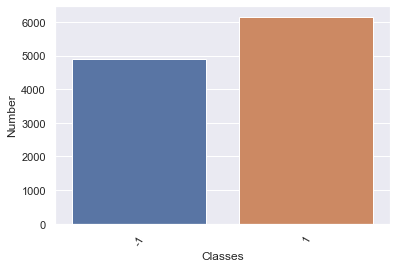

In [0]:
sns.set(style="darkgrid")
ax = sns.countplot(x = "Result", data = data, order = class_list)
ax.set_xlabel("Classes")
ax.set_ylabel("Number")
labels = ax.get_xticklabels()
for label in labels:
    label.set_rotation(60)
plt.rcParams['figure.figsize'] = (5,5)
plt.show()

## Try default parameters

In [0]:
 xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', gamma = 1,  tree_method = 'gpu_hist', nthread = -1, verbosity = 2)
 xgb_model.fit(new_train_x, train_y)

XGBoostError: [17:38:32] c:\users\administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.h:308: Check failed: gpu_predictor_: 

In [0]:
xgb_model.score(new_test_x,test_y)

## Grid Search using XGBoost Model

In [0]:
 xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', gamma = 1,  tree_method = 'gpu_hist', nthread = -1, verbosity = 2)
 params = {
     'learning_rate' : [0.05, 0.1, 0.5],
     'n_estimators' : [200, 400, 600],
     'max_depth' : [6, 9, 12],
     'subsample': [0.5, 0.8, 1],
     'colsample_bytree': [0.5, 0.8, 1],
     'colsample_bylevel': [0.5, 0.8, 1],
 }
 xgb_gsm = RandomizedSearchCV(xgb_model, params, n_iter = 10, scoring = ['neg_log_loss', 'accuracy'], n_jobs = -1 , 
                              refit = 'neg_log_loss', cv = 4, verbose = 2, random_state = 7)
 xgb_gsm.fit(new_train_x, train_y)

In [0]:
xgb_gsm.best_params_

## Best Params

{'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 9,
 'n_estimators': 200,
 'subsample': 0.8}

## Best Model
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=2)

In [0]:
xgb_model_best = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=1,
                learning_rate=0.1, max_delta_step=0, max_depth=12,
                min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
                nthread=-1, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, tree_method='gpu_hist', verbosity=2)
xgb_model_best.fit(train_x,train_y)

# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(xgb_model_best, open(filename, 'wb'))

## Predict on Test

In [0]:
xgb_model_best.score(test_x,test_y)

## Experiments

In [0]:
## Testing
sk_folds = StratifiedKFold(n_splits = 3)

tot_loss = 0
tot_acc = 0
count = 1
for train_idx, val_idx in sk_folds.split(new_train_x, train_y):
    x_train, y_train = new_train_x[train_idx], train_y[train_idx]
    x_val, y_val = new_train_x[val_idx], train_y[val_idx]
    xgb_model_best.fit(x_train, y_train)

    # Train
    train_preds = xgb_model_best.predict_proba(x_train)
    train_loss = log_loss(y_train, train_preds)
    
    # Val
    val_preds = xgb_model_best.predict_proba(x_val)
    val_loss = log_loss(y_val, val_preds)
    val_acc = accuracy_score(y_val, xgb_model_best.predict(x_val))

    print("Split: {0}\tTraining Loss:{1:.4f}\tValidation Loss:{2:.4f}".format(count, train_loss, val_loss))

    # Total
    tot_loss += val_loss
    tot_acc += val_acc
    count+=1
print("\nAverage Loss:{}\nAverage Accuracy:{}".format(tot_loss/3, (tot_acc/3)*100))